<a href="https://colab.research.google.com/github/Y2Data/DLwP-keras/blob/main/naiveCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tim2dai","key":"b7f3915dd9459a3ac01eec0e475bdbf1"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 96% 260M/271M [00:01<00:00, 187MB/s]
100% 271M/271M [00:01<00:00, 170MB/s]
 96% 524M/543M [00:03<00:00, 171MB/s]
100% 543M/543M [00:03<00:00, 166MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 88.6MB/s]


In [4]:
!unzip -qq train.zip

In [5]:
!mkdir ../content/cats_vs_dogs_small

In [6]:
import os, shutil
from pathlib import Path

ORIGIN = Path('../content/train')
NEW = Path('../content/cats_vs_dogs_small')

def make_subnet(SUB, start, end):
    for category in ("cat", "dog"):
        DIR = NEW / SUB / category
        os.makedirs(DIR)
        fnames = [f"{category}.{i}.jpg" for i in range(start, end)]
        for fname in fnames:
            shutil.copyfile(src = ORIGIN / fname,
                            dst = DIR / fname)

In [7]:
make_subnet("train", 0, 1000)
make_subnet("validation", 1000, 1500)
make_subnet("test", 1500, 2500)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [11]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    NEW / "train",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    NEW / "test",
    image_size=(180, 180),
    batch_size=32)
val_dataset = image_dataset_from_directory(
    NEW / "validation",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="naiveCV.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=30,
    callbacks=callbacks,
    validation_data=val_dataset
)

Epoch 1/30
63/63 [==============================] - 21s 77ms/step - loss: 0.7265 - accuracy: 0.5185 - val_loss: 0.6945 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 5s 70ms/step - loss: 0.7187 - accuracy: 0.5505 - val_loss: 0.6797 - val_accuracy: 0.5330
Epoch 3/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6582 - accuracy: 0.6100 - val_loss: 0.6792 - val_accuracy: 0.5710
Epoch 4/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6631 - accuracy: 0.6220 - val_loss: 0.6604 - val_accuracy: 0.6180
Epoch 5/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6152 - accuracy: 0.6785 - val_loss: 0.6211 - val_accuracy: 0.6760
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5751 - accuracy: 0.7065 - val_loss: 0.6186 - val_accuracy: 0.6780
Epoch 7/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5152 - accuracy: 0.7375 - val_loss: 0.6932 - val_accuracy: 0.6940
Epoch 8/30
6

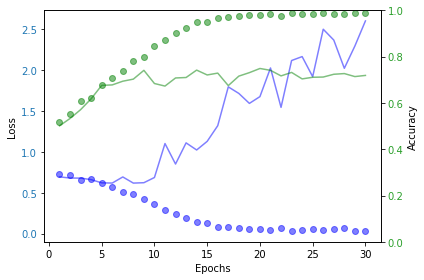

In [15]:
# plotting loss & accuracy
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
acc = history.history["accuracy"] 
val_acc = history.history["val_accuracy"] 
epochs = range(1, len(loss) + 1) 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(epochs, loss, "bo", label="Train loss", alpha=0.5) 
ax1.plot(epochs, val_loss, "b", label="Val loss", alpha=0.5) 
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel("Epochs") 
ax1.set_ylabel("Loss") 

ax2.set_ylabel("Accuracy")
ax2.set_ylim(top=1.0)
ax2.plot(epochs, acc, "go", label="Train acc", alpha=0.5) 
ax2.plot(epochs, val_acc, "g", label="Val acc", alpha=0.5) 
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
# fig.legend(loc='upper left')
plt.show()


In [16]:
test_model = keras.models.load_model("naiveCV.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test loss: {}\n accuracy: {:.4f}".format(test_loss, test_acc))

63/63 [==============================] - 3s 37ms/step - loss: 0.6590 - accuracy: 0.6670
Test loss: 0.6589857339859009
 accuracy: 0.6670


In [17]:
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


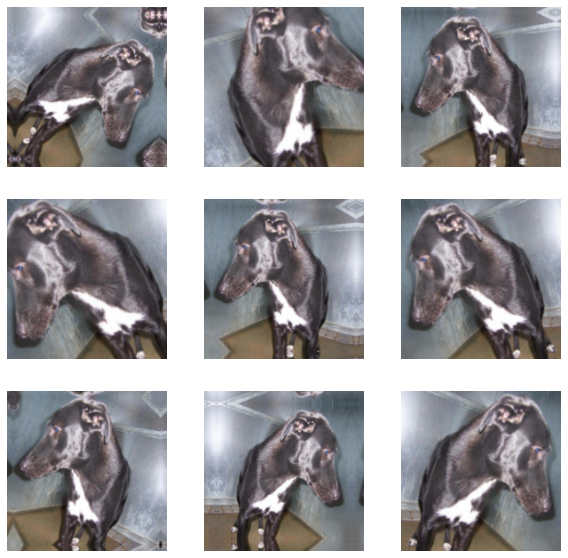

In [18]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(42):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_aug(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
new_model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
new_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
new_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="naiveCVwithDataAug.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [21]:
history = new_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=new_callbacks
)

Epoch 1/100
63/63 [==============================] - 6s 75ms/step - loss: 0.7006 - accuracy: 0.4905 - val_loss: 0.6922 - val_accuracy: 0.5560
Epoch 2/100
63/63 [==============================] - 5s 72ms/step - loss: 0.7334 - accuracy: 0.5135 - val_loss: 0.7058 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 0.7011 - accuracy: 0.5670 - val_loss: 0.6824 - val_accuracy: 0.5340
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6723 - accuracy: 0.5950 - val_loss: 0.6698 - val_accuracy: 0.5940
Epoch 5/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6628 - accuracy: 0.6270 - val_loss: 0.6248 - val_accuracy: 0.6410
Epoch 6/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6151 - accuracy: 0.6595 - val_loss: 0.6321 - val_accuracy: 0.6260
Epoch 7/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6297 - accuracy: 0.6645 - val_loss: 0.6529 - val_accuracy: 0.6120
Epoch 

In [22]:
test_model = keras.models.load_model("naiveCVwithDataAug.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test loss: {}\n accuracy: {:.4f}".format(test_loss, test_acc))

63/63 [==============================] - 3s 38ms/step - loss: 0.5267 - accuracy: 0.8000
Test loss: 0.5267313718795776
 accuracy: 0.8000


In [23]:
plt.style.use('seaborn-pastel')

def plot_loss_acc(history):
    loss = history.history["loss"] 
    val_loss = history.history["val_loss"] 
    acc = history.history["accuracy"] 
    val_acc = history.history["val_accuracy"] 
    epochs = range(1, len(loss) + 1) 

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(epochs, loss, "bo", label="Train loss", alpha=0.5) 
    ax1.plot(epochs, val_loss, "b", label="Val loss", alpha=0.5) 
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel("Epochs") 
    ax1.set_ylabel("Loss") 

    ax2.set_ylabel("Accuracy")
    ax2.set_ylim(top=1.0)
    ax2.plot(epochs, acc, "go", label="Train acc", alpha=0.5) 
    ax2.plot(epochs, val_acc, "g", label="Val acc", alpha=0.5) 
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()
    # fig.legend(loc='upper left')
    plt.show()

def plot_loss(history):
    loss = history.history["loss"] 
    val_loss = history.history["val_loss"] 
    epochs = range(1, len(loss) + 1) 
    plt.plot(epochs, loss, "bo", label="Training loss") 
    plt.plot(epochs, val_loss, "b", label="Validation loss") 
    plt.title("Training and validation loss") 
    plt.xlabel("Epochs") 
    plt.ylabel("Loss") 
    plt.legend() 
    plt.show()

def plot_acc(history):
    plt.clf() 
    acc = history.history["accuracy"] 
    val_acc = history.history["val_accuracy"] 
    epochs = range(1, len(acc) + 1) 
    plt.plot(epochs, acc, "bo", label="Training accuracy") 
    plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
    plt.title("Training and validation accuracy") 
    plt.xlabel("Epochs") 
    plt.ylabel("Accuracy") 
    plt.legend() 
    plt.show()

In [24]:
vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58892288/58889256 [==============================] - 1s 0us/step


In [25]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [26]:
import numpy as np
def get_all_features_and_labels(dataset):
    all_features, all_labels = [], []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = vgg16_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [27]:
inputs = layers.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [28]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [29]:
train_features, train_labels =  get_all_features_and_labels(train_dataset) 
val_features, val_labels =  get_all_features_and_labels(val_dataset) 
test_features, test_labels =  get_all_features_and_labels(test_dataset)

In [30]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 6ms/step - loss: 15.5623 - accuracy: 0.9215 - val_loss: 3.3773 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 3.7040 - accuracy: 0.9775 - val_loss: 5.6300 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 3.2099 - accuracy: 0.9790 - val_loss: 4.5292 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 1.8542 - accuracy: 0.9880 - val_loss: 4.2530 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.9376 - accuracy: 0.9945 - val_loss: 6.3414 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.3486 - accuracy: 0.9905 - val_loss: 8.3835 - val_accuracy: 0.9590
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.4526 - accuracy: 0.9935 - val_loss: 6.2775 - val_accuracy: 0.9730
Epoch 8/20
63/63 [=

In [31]:
vgg16_frozen = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
vgg16_frozen.trainable = False

In [32]:
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2)])

In [33]:
inputs = layers.Input(shape=(180, 180, 3))
x = data_aug(inputs)
x = vgg16_frozen(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [34]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_aug.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [35]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - 9s 114ms/step - loss: 26.6074 - accuracy: 0.8535 - val_loss: 23.1340 - val_accuracy: 0.8930
Epoch 2/50
63/63 [==============================] - 7s 112ms/step - loss: 15.1188 - accuracy: 0.9010 - val_loss: 5.9117 - val_accuracy: 0.9530
Epoch 3/50
63/63 [==============================] - 7s 113ms/step - loss: 11.6297 - accuracy: 0.9215 - val_loss: 7.3397 - val_accuracy: 0.9480
Epoch 4/50
63/63 [==============================] - 7s 112ms/step - loss: 6.9439 - accuracy: 0.9370 - val_loss: 5.0533 - val_accuracy: 0.9560
Epoch 5/50
63/63 [==============================] - 7s 114ms/step - loss: 7.2974 - accuracy: 0.9355 - val_loss: 7.1139 - val_accuracy: 0.9500
Epoch 6/50
63/63 [==============================] - 7s 113ms/step - loss: 6.0101 - accuracy: 0.9405 - val_loss: 7.0905 - val_accuracy: 0.9460
Epoch 7/50
63/63 [==============================] - 7s 112ms/step - loss: 5.3390 - accuracy: 0.9410 - val_loss: 7.7873 - val_accuracy: 0.9460
Ep

In [36]:
test_model = keras.models.load_model("feature_extraction_with_data_aug.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test loss: {}, test accuracy: {:.4f}".format(test_loss, test_acc))

63/63 [==============================] - 5s 72ms/step - loss: 1.4112 - accuracy: 0.9690
Test loss: 1.4112329483032227, test accuracy: 0.9690


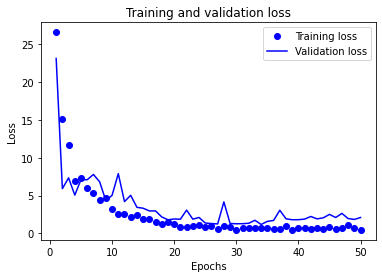

In [37]:
plot_loss(history)

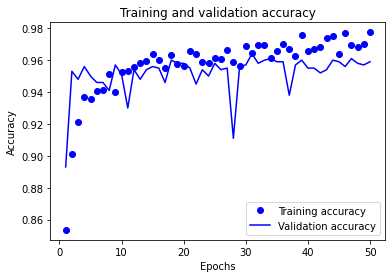

In [38]:
plot_acc(history)

In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257 

In [40]:
vgg16_frozen.trainable = True
for layer in vgg16_frozen.layers[:-4]:
    layer.trainable = False

In [41]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [42]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 124ms/step - loss: 0.6164 - accuracy: 0.9720 - val_loss: 1.9829 - val_accuracy: 0.9570
Epoch 2/30
63/63 [==============================] - 8s 120ms/step - loss: 0.3948 - accuracy: 0.9765 - val_loss: 1.8667 - val_accuracy: 0.9590
Epoch 3/30
63/63 [==============================] - 8s 120ms/step - loss: 0.3756 - accuracy: 0.9785 - val_loss: 1.6108 - val_accuracy: 0.9620
Epoch 4/30
63/63 [==============================] - 8s 120ms/step - loss: 0.3501 - accuracy: 0.9785 - val_loss: 1.6660 - val_accuracy: 0.9590
Epoch 5/30
63/63 [==============================] - 8s 120ms/step - loss: 0.2805 - accuracy: 0.9815 - val_loss: 2.1984 - val_accuracy: 0.9440
Epoch 6/30
63/63 [==============================] - 8s 119ms/step - loss: 0.3039 - accuracy: 0.9815 - val_loss: 1.5272 - val_accuracy: 0.9610
Epoch 7/30
63/63 [==============================] - 8s 120ms/step - loss: 0.2562 - accuracy: 0.9825 - val_loss: 1.4831 - val_accuracy: 0.9650
Epoch 

In [43]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print("Test loss: {}, test accuracy: {:.4f}".format(test_loss, test_acc))

63/63 [==============================] - 5s 72ms/step - loss: 1.2070 - accuracy: 0.9705
Test loss: 1.206950306892395, test accuracy: 0.9705
